In [1]:
import os

import matplotlib.pyplot as plt
import tifffile as tf
import pandas as pd
import numpy as np

import skimage.measure as measure

import line_utils

In [2]:
# Establish the path the Excel file
base_path = "/Users/zachcm/Documents/Projects/ExM_Nadja/01_Macros_Analysis/"
workbook = "20241008_septin2_tubulin.xlsx"
workbook_path = os.path.join(base_path, workbook)
expected_colnames=['Distance_(microns)', 'MTs', 'septin2', 'DAPI']

In [3]:
# Load the table of contents
toc = pd.read_excel(workbook_path, sheet_name="ToC + P-t-p", header=2)

In [4]:
# load FWHM_along, which contains other statistics
metrics = pd.read_excel(workbook_path, sheet_name="FWHM_along", header=0).dropna(axis=0)

In [5]:
metrics = line_utils.merge_df_information(toc, 
                                          metrics, 
                                          id_key="Label", 
                                          mapped_keys=["dX (µm)", "dX (pxl)", "X1", "X2", "Angle","X","Y","length"])

In [6]:
# Let's load all of the normal sheets...
sheet_names = ["Septin2_RC_along", "Septin2_CS_along", "Septin2_RS_along", 
               "Septin2_SM_along", "Septin2_BA_along", "Septin2_A_along"]

res = {}
for sheet_name in sheet_names:
    line_utils.load_line_profiles(workbook_path, sheet_name, expected_colnames=expected_colnames, res=res)

In [7]:
# Now let's get the original images 
import glob

max_proj_path = "/Volumes/Ries_Ewers/Septin2-GFP/MaxIPs"
max_proj_files = glob.glob(max_proj_path+"/*.tif")

/Users/zachcm/Code/expansion-analysis/line_utils.py:263: RuntimeWarning: invalid value encountered in add
  return np.real((r*np.exp((-5*np.pi*(2j*r*t + 5*np.pi*sig**2))/(2.*r**2))*(12*spec.jv(1,5*np.pi)*(spec.erf((r*(r + t) - 5j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r**2 - r*t + 5j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + (spec.erf((r**2 - r*t - 5j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r*(r + t) + 5j*np.pi*sig**2)/(np.sqrt(2)*r*sig)))*np.exp((10j*np.pi*t)/r)) + 60*spec.jv(1,np.pi)*((spec.erf((r**2 - r*t - 1j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r*(r + t) + 1j*np.pi*sig**2)/(np.sqrt(2)*r*sig)))*np.exp((6*np.pi*(1j*r*t + 2*np.pi*sig**2))/r**2) + (spec.erf((r*(r + t) - 1j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r**2 - r*t + 1j*np.pi*sig**2)/(np.sqrt(2)*r*sig)))*np.exp((4*np.pi*(1j*r*t + 3*np.pi*sig**2))/r**2)) + 20*spec.jv(1,3*np.pi)*((spec.erf((r**2 - r*t - 3j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r*(r + t) + 3j*np.pi*sig**2)/(np.sqrt(2)*r*sig)))*np.exp

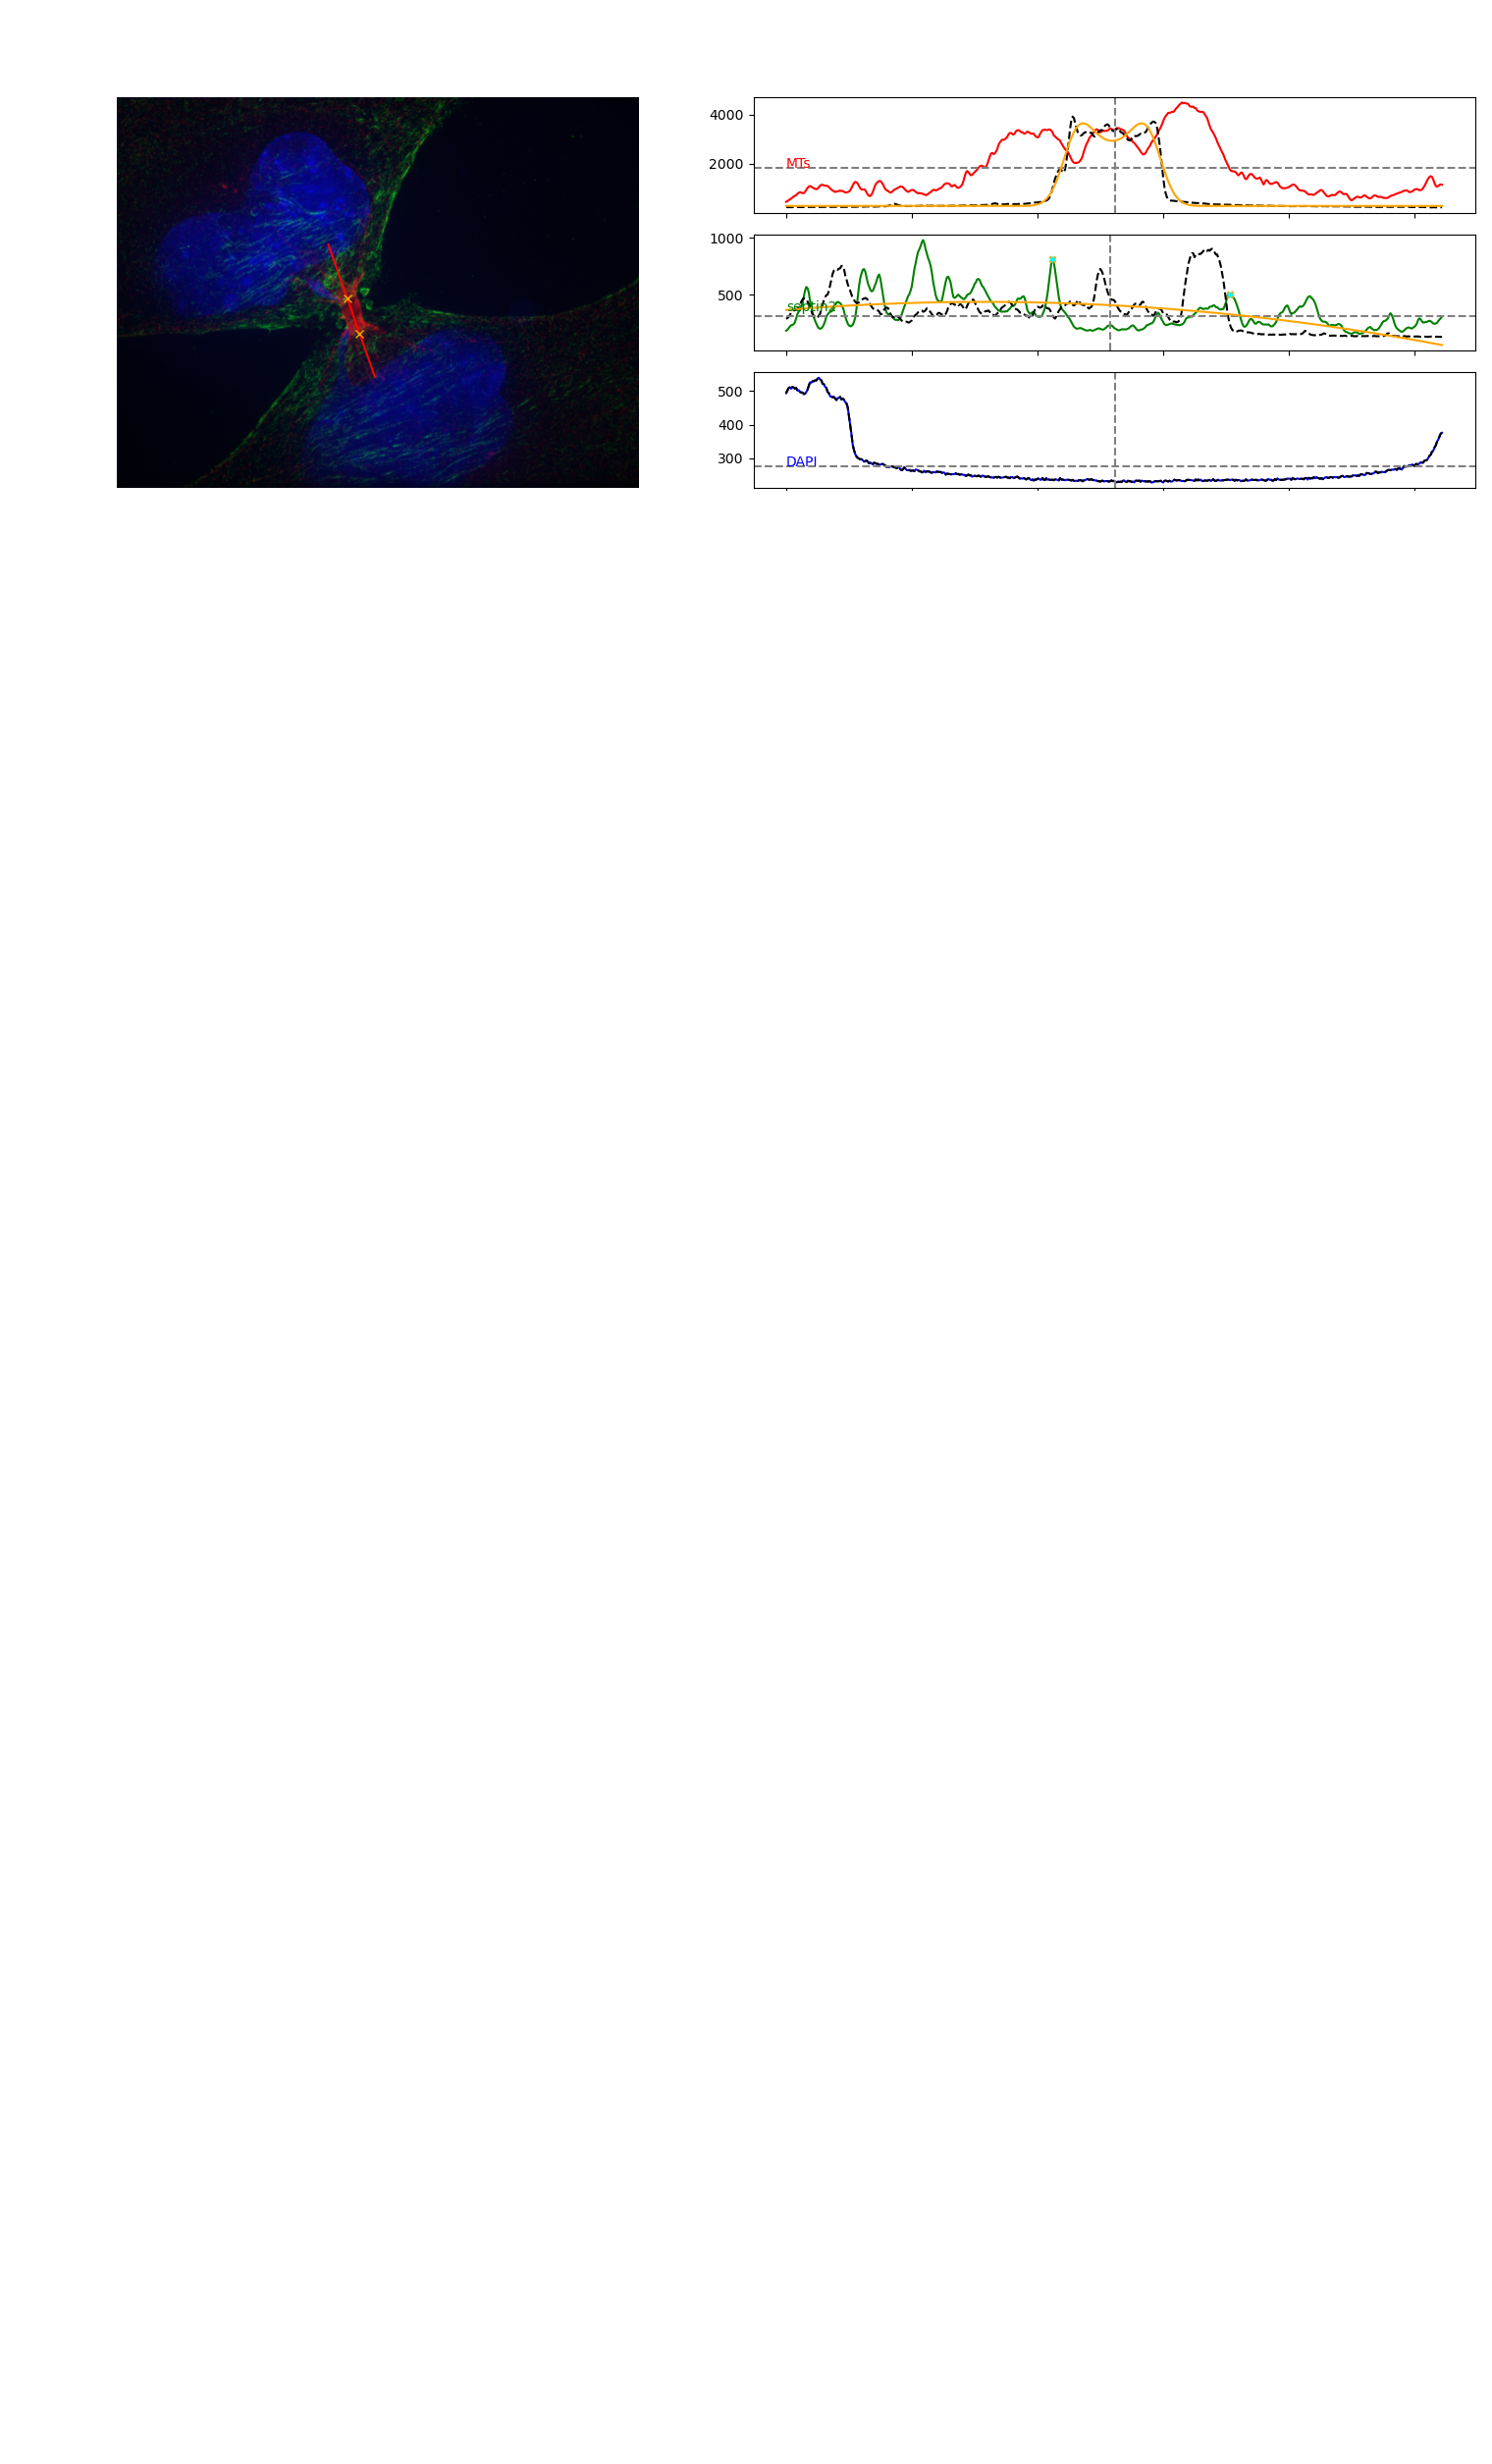

In [8]:
# from skimage.filters import threshold_otsu

N = 5
# fig, ax = plt.subplots(16,N,figsize=(20,4*16))
fig = plt.figure(figsize=(15,5*N))
subfigs = fig.subfigures(N,1)
j = 0
metrics['dX2'] = np.nan
metrics['X12'] = np.nan
metrics['X22'] = np.nan
metrics['septin_ring_diameter_avg'] = np.nan
for i, ml in metrics.iterrows():
    # Get the image associated with this row
    im = None
    for fn in max_proj_files:
        if ml["Label"] in fn:
            im = tf.imread(fn)
            break

    # get x, y, angle, length for this row
    x, y, angle, length = ml[["X", "Y", "Angle", "length"]]

    # Compute the line end points
    xl, xu, yl, yu = line_utils.get_line_profile_endpoints(x, y, angle, length)

    # get the corresponding line profiles
    for key, val in res.items():
        if ml["Label"] in key:
            lp = val

    chs = measure.profile_line(im.T, 
                              [xl, yu], 
                              [xu, yl], 
                              linewidth=25)

    mt, septin, dapi = chs.T

    # line profile metrics we'll use later
    mt_mean,  mt_mid= np.mean(mt), len(mt)/2
    dapi_mean, dapi_mid = np.mean(dapi), len(dapi)/2
    min_septin, max_septin = np.min(septin), np.max(septin)

    # --------- Fit septin peaks ---------

    # Find peaks in the septin channel
    peaks, peak_props, septin_threshold = line_utils.get_peaks(septin)
    # weight the peaks by the MT channel signal
    w, profile_center, sig = line_utils.compute_peak_weights(mt, peaks)
    # Find the two peaks most likely to be septin rings
    p0, p1 = line_utils.find_two_best_peaks(peaks, peak_props, septin_threshold, profile_center, w)
    
    # Get the distance between the peaks
    dX2 = np.abs(p0-p1)
    metrics.loc[i,['X12','X22','dX2']] = [p0, p1, dX2]

    # --------- Fit septin rings ---------
    p0x, p0y = line_utils.get_image_coordinate_from_distance_along_line(p0, xl, xu, yl, yu, len(septin))
    p1x, p1y = line_utils.get_image_coordinate_from_distance_along_line(p1, xl, xu, yl, yu, len(septin))

    # Now get the orthogonal line profile at the line center
    xl3, xu3, yl3, yu3 = line_utils.get_line_profile_endpoints(p0x, p0y, angle-90, length)
    chs = measure.profile_line(im.T, 
                              [xl3, yu3], 
                              [xu3, yl3], 
                              linewidth=25)
    _, septin_ring0, _ = chs.T

    ring0_diameter, res_lsq_ring0 = line_utils.fit_gaussian_fwhm(septin_ring0, return_dict=True)

    # Now get the orthogonal line profile at the line center
    xl4, xu4, yl4, yu4 = line_utils.get_line_profile_endpoints(p1x, p1y, angle-90, length)
    chs = measure.profile_line(im.T, 
                              [xl4, yu4], 
                              [xu4, yl4], 
                              linewidth=25)
    _, septin_ring1, _ = chs.T

    ring1_diameter, _ = line_utils.fit_gaussian_fwhm(septin_ring1, return_dict=True)

    metrics.loc[i,'septin_ring_diameter_avg'] = 0.5*(ring0_diameter + ring1_diameter)

    # --------- Fit center MT cross-section ---------
    # Now get the orthogonal line profile at the line center
    xl2, xu2, yl2, yu2 = line_utils.get_line_profile_endpoints(x, y, angle-90, length)
    chs = measure.profile_line(im.T, 
                              [xl2, yu2], 
                              [xu2, yl2], 
                              linewidth=25)
    mt, _, _ = chs.T

    outer_diameter, res_lsq = line_utils.fit_tubule_diameter(mt, return_dict=True)
    metrics.loc[i,'diamM2'] = outer_diameter


    # (metrics.loc[i,'dX2'] != metrics.loc[i,'dX (pxl)']) or
    # (np.abs(metrics.loc[i,'diamM2'] - metrics.loc[i,'diamM']) > 10)
    # if (j < (N-1)) and (np.abs(metrics.loc[i,'dX2'] - metrics.loc[i,'dX (pxl)']) > 50) and metrics.loc[i, 'Unnamed: 0'] == "SM":
    if (j < (N-1)) and (metrics.loc[i,'septin_ring_diameter_avg'] > 1000):
        # print(f"Calculate difference: {metrics.loc[i,'dX2']} original difference: {metrics.loc[i,'dX (pxl)']}")
        maxidx = min(mt.shape[0], lp.shape[0])
        septin_weight = max_septin*np.exp(-((np.arange(maxidx)-profile_center)**2)/(2*sig*sig))+septin_threshold
        line_utils.image_with_profiles(subfigs[j], 
                                       im, xl, xu, yl, yu, 
                                       channel_names=expected_colnames[1:], linewidth=25,
                                       # precalc_channel_profiles=lp[["MTs", "septin2", "DAPI"]].to_numpy(),
                                       precalc_channel_profiles=np.vstack([mt[:maxidx], septin_ring0[:maxidx], lp[["DAPI"]].to_numpy()[:maxidx,:].T]).T,
                                       precalc_peaks=[None, [[p0,p1], [int(metrics.loc[i,'X1']), int(metrics.loc[i,'X2'])]], None],
                                       precalc_peak_coords=[(p0x,p0y),(p1x,p1y)],
                                       precalc_fits=[(line_utils.gauss_convolved_annulus_approx, res_lsq.x), (line_utils.gauss, res_lsq_ring0.x), None],
                                       precalc_means=[mt_mean,septin_threshold,dapi_mean],
                                       precalc_midpoints=[mt_mid,profile_center,dapi_mid],
                                       title = os.path.basename(fn),      
        )
        j += 1

    # if (j==5):
    #     break


fig.tight_layout()#pad=0.4, w_pad=0.5, h_pad=1.0)

49380.0


Text(0.5, 1.0, 'chi2_dist')

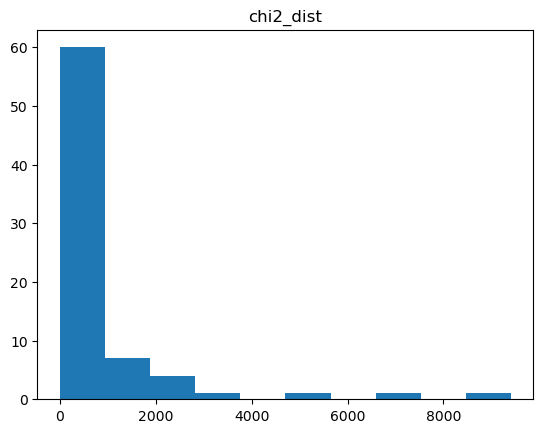

In [9]:
import eval_utils

chi2_dist = eval_utils.min_chi2_dist(metrics['X1'],metrics['X2'],metrics['X12'],metrics['X22'])

print(chi2_dist.sum())
plt.hist(chi2_dist)
plt.title('chi2_dist')

Text(0.5, 1.0, '|dX (pxl) - dX2|')

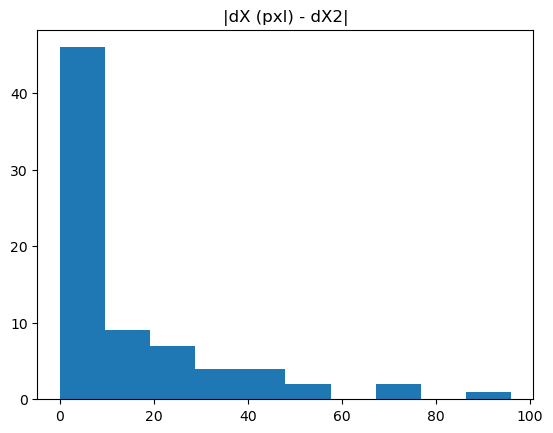

In [10]:
plt.hist(np.abs(metrics['dX (pxl)'] - metrics['dX2']))
plt.title('|dX (pxl) - dX2|')

<Axes: xlabel='Unnamed: 0', ylabel='dX2'>

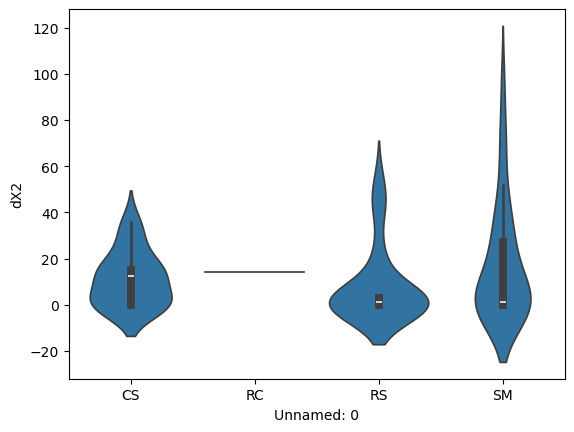

In [11]:
import seaborn as sns

sns.violinplot(metrics.groupby('Unnamed: 0')[['dX (pxl)', 'dX2']].diff(axis=1)[['dX2']].abs(), x="Unnamed: 0", y="dX2")

Text(0.5, 1.0, '|diamM - diamM2|')

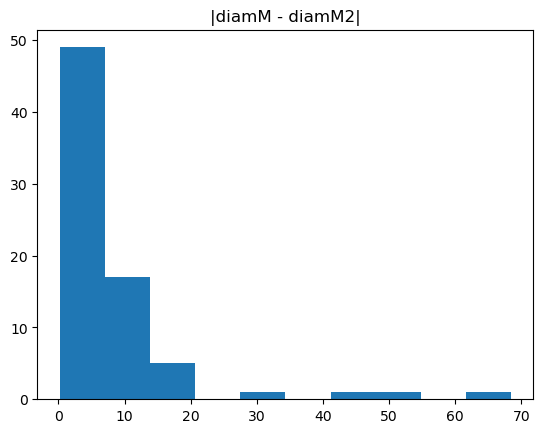

In [12]:
plt.hist(np.abs(metrics['diamM'] - metrics['diamM2']))
plt.title('|diamM - diamM2|')

<Axes: xlabel='Unnamed: 0', ylabel='diamA'>

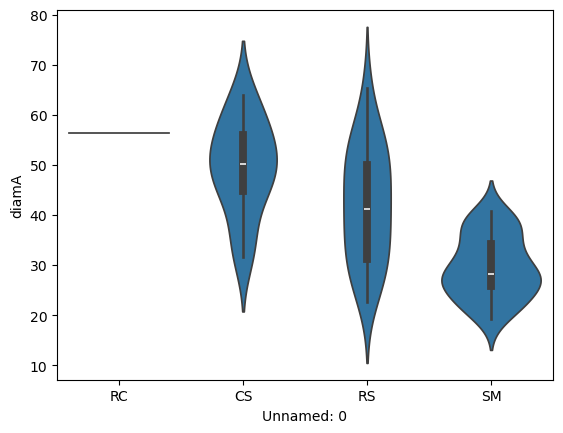

In [13]:
sns.violinplot(metrics, x="Unnamed: 0", y="diamA")

<Axes: xlabel='Unnamed: 0', ylabel='dX2'>

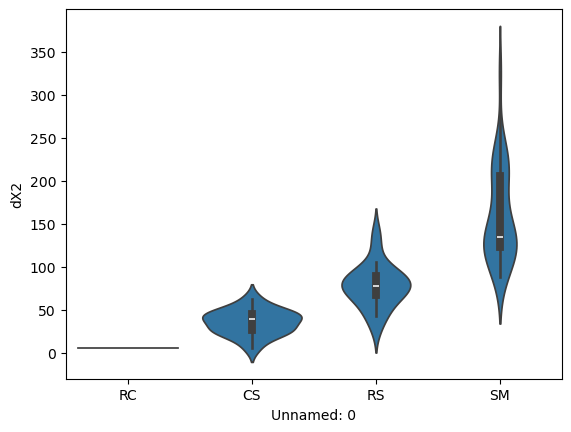

In [14]:
sns.violinplot(metrics, x="Unnamed: 0", y="dX2")

<Axes: xlabel='Unnamed: 0', ylabel='dX (pxl)'>

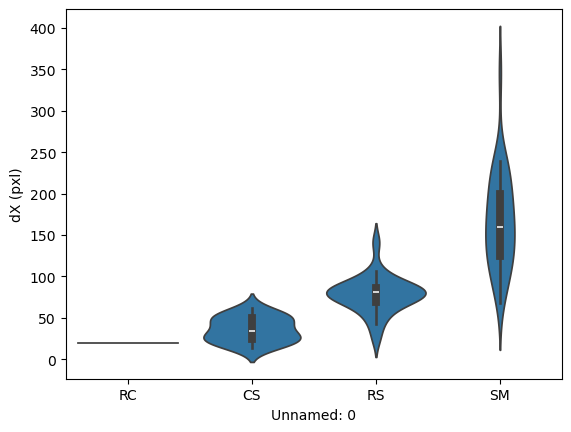

In [15]:
sns.violinplot(metrics, x="Unnamed: 0", y="dX (pxl)")

<Axes: xlabel='Unnamed: 0', ylabel='diamM'>

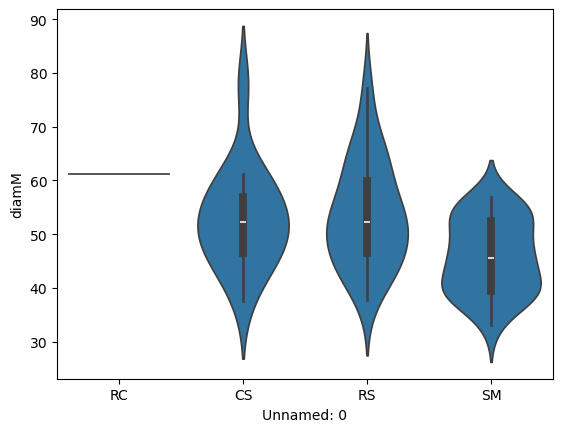

In [16]:
sns.violinplot(metrics, x="Unnamed: 0", y="diamM")

<Axes: xlabel='Unnamed: 0', ylabel='diamM2'>

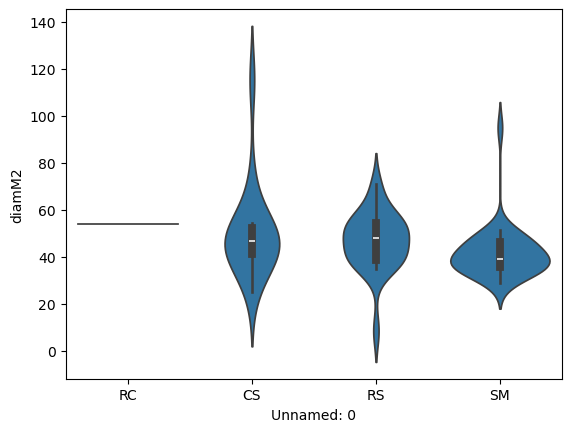

In [17]:
sns.violinplot(metrics, x="Unnamed: 0", y="diamM2")

(0.0, 400.0)

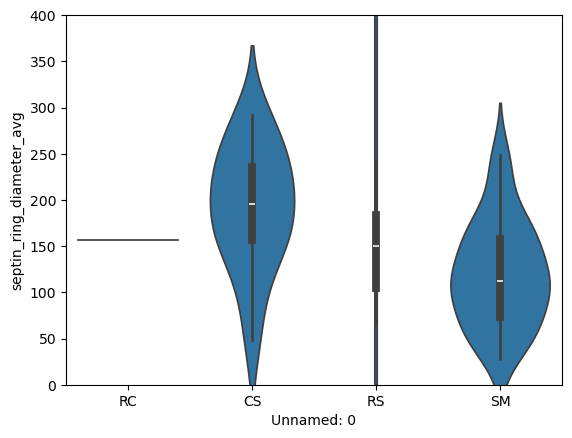

In [18]:
sns.violinplot(metrics, x="Unnamed: 0", y="septin_ring_diameter_avg")
plt.ylim([0,400])